<a href="https://colab.research.google.com/github/Charlotte-99/Classifying_Cosmological_Data/blob/main/Copy_of_regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Regularisation**

In this example you are given a dataset (MNIST) with a limited number of training examples (only 1000 compared to the usual 60,000). 

Your goal is to implement regularisation methods to achive the **lowest possible test loss using this dataset**. 

You should consider methods given in the lectures including:

*   Data augmentation
*   Early stopping
*   L1/L2 penalty norms
*   Dropout

You are free to change the network architecture and model complexity, but the main purpose of the workshop is to investigate regularisation (next week you will look at CNN architectures in detail). 

You are also free to change the choice of optimiser, and other hyper-parameters such as the batch size.  


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.python.keras import regularizers

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import numpy as np

In [ ]:
tf.random.set_seed(1)

In [ ]:
print(tf.__version__)

2.4.1


First load the MNIST dataset and add a channels dimension (channels last convention)

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[..., tf.newaxis].astype(np.float32)
x_test = x_test[..., tf.newaxis].astype(np.float32)

img_rows = x_train.shape[1]
img_cols = x_train.shape[2]

11493376/11490434 [==============================] - 0s 0us/step


Let's use a much smaller training dataset of 1000 examples so overfitting is more problematic

In [ ]:
n_train = 1000
x_train = x_train[0:n_train, :]
y_train = y_train[0:n_train]

print(x_train.shape)
print(x_test.shape)

(1000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Let's visualise several training examples - to do this we use the keras ImageDataGenerator. We rescale images by 1/255 to normalise them in the range (0, 1)

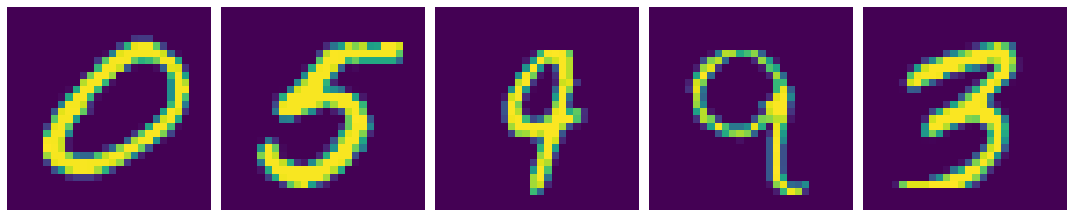

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255) 
data_gen = image_generator.flow(x_train, y_train, batch_size=32) 
sample_images, sample_labels = next(data_gen)
plotImages(sample_images[:5])

One regularisation method to deal with over-fitting is data augmentation. The image generator can apply various transformations to data - here we apply a random rotation of upto 20 degrees and visualise the same training example with different augmentations

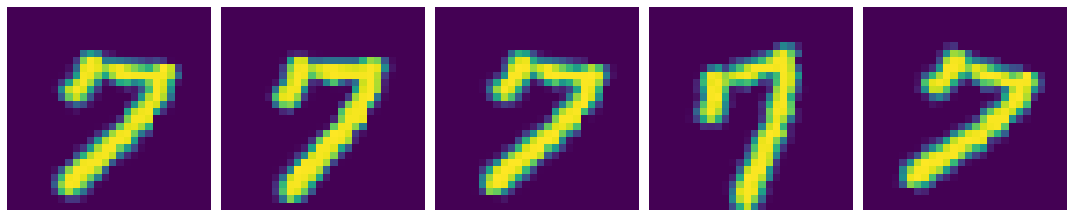

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255, 
                                     rotation_range=20) 
data_gen = image_generator.flow(x_train, y_train, batch_size=32) 
augmented_images = [data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Define a basic CNN with 32 convolutional filters using a 3x3 kernel, followed by a dense fully connected layer of 128 units and an output layer of 10 units with softmax activation 

In [ ]:
class BasicCNN(Model):
  def __init__(self):
    super(BasicCNN, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

Main training routine - uses the more detailed Gradient Tape API to iterate over the dataset and update the weights

In [ ]:
def trainer(cls, train_image_generator, test_image_generator, 
            verbose=False, batch_size=32, max_epochs=5, early_stopping=False,
            patience=10):
  
  model = cls()

  train_data_gen = train_image_generator.flow(x_train, y_train, 
                                              batch_size=batch_size) 

  test_data_gen = test_image_generator.flow(x_test, y_test, 
                                              batch_size=batch_size) 

  loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
  optimizer = tf.keras.optimizers.Adam()

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='train_accuracy')

  test_loss = tf.keras.metrics.Mean(name='test_loss')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='test_accuracy')
  
  #Variables stored for use in plotting results
  global stored_test_loss
  global stored_train_loss
  global epoch_number

  stored_test_loss = []
  stored_train_loss = []
  epoch_number = []

  #Count for early stopping procedure
  final_test_loss = np.inf
  count = 0

  @tf.function
  def train_step(images, labels):
    with tf.GradientTape() as tape:
      predictions = model(images, training=True)
      loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

  @tf.function
  def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

  for epoch in range(max_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    batches = 0
    for images, labels in train_data_gen:
      train_step(images, labels)
      batches += 1
      if batches >= len(x_train) / batch_size:
        break

    batches = 0
    for images, labels in test_data_gen:
      test_step(images, labels)
      batches += 1
      if batches >= len(x_test) / batch_size:
        break

    epoch_number.append(epoch+1)
    stored_test_loss.append(test_loss.result())
    stored_train_loss.append(train_loss.result())

    if verbose:
      template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
      print(template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))
      
    #Early stopping procedure
    if early_stopping:
      if test_loss.result().numpy() < final_test_loss:
        final_test_loss = test_loss.result().numpy()
        count = 0
      count += 1
      if count > patience:
        break
    else:
      final_test_loss = test_loss.result().numpy()


  return final_test_loss

Baseline run with no regularisation

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=20)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 0.9098917841911316, Accuracy: 71.9000015258789, Test Loss: 0.5525864362716675, Test Accuracy: 82.66000366210938
Epoch 2, Loss: 0.29125910997390747, Accuracy: 91.79999542236328, Test Loss: 0.44551023840904236, Test Accuracy: 85.57999420166016
Epoch 3, Loss: 0.15443973243236542, Accuracy: 94.9000015258789, Test Loss: 0.4128546714782715, Test Accuracy: 87.7300033569336
Epoch 4, Loss: 0.0735902190208435, Accuracy: 98.4000015258789, Test Loss: 0.3932322561740875, Test Accuracy: 88.77000427246094
Epoch 5, Loss: 0.03226456046104431, Accuracy: 99.4000015258789, Test Loss: 0.40493279695510864, Test Accuracy: 89.17000579833984
Epoch 6, Loss: 0.02335136942565441, Accuracy: 99.5, Test Loss: 0.43074142932891846, Test Accuracy: 88.58000183105469
Epoch 7, Loss: 0.012759704142808914, Accuracy: 99.80000305175781, Test Loss: 0.46199727058410645, Test Accuracy: 87.9800033569336
Epoch 8, Loss: 0.011929976753890514, Accuracy: 99.9000015258789, Test Loss: 0.41806283593177795, Test Accuracy: 8

Run with early stopping implemented, patience set to 10

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=50, early_stopping=True, 
                          patience=10)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 0.8712573647499084, Accuracy: 72.0999984741211, Test Loss: 0.5114477276802063, Test Accuracy: 83.27000427246094
Epoch 2, Loss: 0.2919911742210388, Accuracy: 91.69999694824219, Test Loss: 0.38079550862312317, Test Accuracy: 88.26000213623047
Epoch 3, Loss: 0.136837437748909, Accuracy: 96.80000305175781, Test Loss: 0.3725722134113312, Test Accuracy: 89.20000457763672
Epoch 4, Loss: 0.0856371745467186, Accuracy: 97.79999542236328, Test Loss: 0.45062392950057983, Test Accuracy: 87.43000030517578
Epoch 5, Loss: 0.04413197934627533, Accuracy: 99.5, Test Loss: 0.3708578050136566, Test Accuracy: 89.4000015258789
Epoch 6, Loss: 0.015953322872519493, Accuracy: 99.9000015258789, Test Loss: 0.38121578097343445, Test Accuracy: 89.61000061035156
Epoch 7, Loss: 0.00858557689934969, Accuracy: 100.0, Test Loss: 0.3959033489227295, Test Accuracy: 89.9800033569336
Epoch 8, Loss: 0.004672711715102196, Accuracy: 100.0, Test Loss: 0.39677703380584717, Test Accuracy: 90.16000366210938
Epoch 9,

Run with early stopping and data augmentation experimentation

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range = 25,
                                           zoom_range=0.3,
                                           height_shift_range=0.2) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=50, early_stopping=True, 
                          patience=10)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 1.9299007654190063, Accuracy: 32.900001525878906, Test Loss: 1.294492483139038, Test Accuracy: 58.79999923706055
Epoch 2, Loss: 1.5481070280075073, Accuracy: 48.5, Test Loss: 1.0227113962173462, Test Accuracy: 68.06999969482422
Epoch 3, Loss: 1.2500030994415283, Accuracy: 60.5, Test Loss: 0.7819686532020569, Test Accuracy: 74.70999908447266
Epoch 4, Loss: 1.0463765859603882, Accuracy: 67.5999984741211, Test Loss: 0.755093514919281, Test Accuracy: 74.23999786376953
Epoch 5, Loss: 0.9163070321083069, Accuracy: 72.5999984741211, Test Loss: 0.613361656665802, Test Accuracy: 81.80000305175781
Epoch 6, Loss: 0.7765957117080688, Accuracy: 75.4000015258789, Test Loss: 0.44531649351119995, Test Accuracy: 86.77999877929688
Epoch 7, Loss: 0.70326167345047, Accuracy: 78.19999694824219, Test Loss: 0.3978829085826874, Test Accuracy: 88.16000366210938
Epoch 8, Loss: 0.6024054288864136, Accuracy: 81.9000015258789, Test Loss: 0.3793199360370636, Test Accuracy: 88.6500015258789
Epoch 9, L

Experimenting with changing batch size


In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, batch_size=5, max_epochs=50, early_stopping=True, 
                          patience=10)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 0.744055986404419, Accuracy: 76.5999984741211, Test Loss: 0.5395098328590393, Test Accuracy: 83.5300064086914
Epoch 2, Loss: 0.21507488191127777, Accuracy: 93.5, Test Loss: 0.5136130452156067, Test Accuracy: 83.60000610351562
Epoch 3, Loss: 0.0689547210931778, Accuracy: 97.89999389648438, Test Loss: 0.45911794900894165, Test Accuracy: 86.23999786376953
Epoch 4, Loss: 0.02017792873084545, Accuracy: 99.80000305175781, Test Loss: 0.37629374861717224, Test Accuracy: 90.18000030517578
Epoch 5, Loss: 0.005205707624554634, Accuracy: 100.0, Test Loss: 0.3794727623462677, Test Accuracy: 90.5
Epoch 6, Loss: 0.0015026138862594962, Accuracy: 100.0, Test Loss: 0.3919656276702881, Test Accuracy: 90.70999908447266
Epoch 7, Loss: 0.0008829007856547832, Accuracy: 100.0, Test Loss: 0.40422722697257996, Test Accuracy: 90.66999816894531
Epoch 8, Loss: 0.0006179864867590368, Accuracy: 100.0, Test Loss: 0.41576698422431946, Test Accuracy: 90.73999786376953
Epoch 9, Loss: 0.0004560282104648649

Experimenting with L1/L2 regularisation - after experimenting with this part, rerun code defining the oribinal BasicCNN function to recover original results

In [ ]:

class BasicCNN(Model):
  def __init__(self):
    super(BasicCNN, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(1))
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1))
    self.d2 = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1))

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

train_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=50, early_stopping=True, 
                          patience=20)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 0.9736719131469727, Accuracy: 70.80000305175781, Test Loss: 0.5470069050788879, Test Accuracy: 81.2699966430664
Epoch 2, Loss: 0.2621080279350281, Accuracy: 92.19999694824219, Test Loss: 0.38493525981903076, Test Accuracy: 88.34000396728516
Epoch 3, Loss: 0.12251728773117065, Accuracy: 96.4000015258789, Test Loss: 0.44464173913002014, Test Accuracy: 86.91999816894531
Epoch 4, Loss: 0.057688966393470764, Accuracy: 98.79999542236328, Test Loss: 0.41482704877853394, Test Accuracy: 88.09000396728516
Epoch 5, Loss: 0.025317542254924774, Accuracy: 99.80000305175781, Test Loss: 0.4118964970111847, Test Accuracy: 88.84000396728516
Epoch 6, Loss: 0.010869738645851612, Accuracy: 100.0, Test Loss: 0.413388192653656, Test Accuracy: 89.4000015258789
Epoch 7, Loss: 0.006387119181454182, Accuracy: 100.0, Test Loss: 0.42606112360954285, Test Accuracy: 89.4800033569336
Epoch 8, Loss: 0.004253786988556385, Accuracy: 100.0, Test Loss: 0.44326767325401306, Test Accuracy: 89.24000549316406
E

Experimenting with dropout layers

In [ ]:
class BasicCNN(Model):
  def __init__(self):
    super(BasicCNN, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.drop1 = Dropout(0.25)
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.drop2 = Dropout(0.4)
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.drop1(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.drop2(x)
    return self.d2(x)

train_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, max_epochs=50, early_stopping=True, 
                          patience=10)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 1.1187340021133423, Accuracy: 64.0999984741211, Test Loss: 0.5200530886650085, Test Accuracy: 83.71000671386719
Epoch 2, Loss: 0.5025155544281006, Accuracy: 85.29999542236328, Test Loss: 0.42437323927879333, Test Accuracy: 87.76000213623047
Epoch 3, Loss: 0.3255288898944855, Accuracy: 91.5999984741211, Test Loss: 0.36504822969436646, Test Accuracy: 89.3800048828125
Epoch 4, Loss: 0.20758500695228577, Accuracy: 94.0999984741211, Test Loss: 0.39157044887542725, Test Accuracy: 87.69999694824219
Epoch 5, Loss: 0.18098247051239014, Accuracy: 93.80000305175781, Test Loss: 0.3762110471725464, Test Accuracy: 88.77000427246094
Epoch 6, Loss: 0.14655327796936035, Accuracy: 95.20000457763672, Test Loss: 0.3583637773990631, Test Accuracy: 89.92000579833984
Epoch 7, Loss: 0.101632259786129, Accuracy: 97.19999694824219, Test Loss: 0.3657341003417969, Test Accuracy: 89.6300048828125
Epoch 8, Loss: 0.08588520437479019, Accuracy: 97.5, Test Loss: 0.33630284667015076, Test Accuracy: 90.47

Experimenting with combinations of all methods used previously to achieve the lowest final test loss

In [ ]:
class BasicCNN(Model):
  def __init__(self):
    super(BasicCNN, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(1))
    self.drop1 = Dropout(0.25)
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1))
    self.drop2 = Dropout(0.4)
    self.d2 = Dense(16, activation='softmax', kernel_regularizer=regularizers.l2(1))

  def call(self, x):
    x = self.conv1(x)
    x = self.drop1(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.drop2(x)
    return self.d2(x)

train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range = 25,
                                           zoom_range=0.3,
                                           width_shift_range=0.2) 
test_image_generator = ImageDataGenerator(rescale=1./255) 
final_test_loss = trainer(BasicCNN, train_image_generator, test_image_generator, 
                          verbose=True, batch_size=16, max_epochs=100, early_stopping=True, 
                          patience=20)
print('Final test loss:', final_test_loss)

Epoch 1, Loss: 2.0893967151641846, Accuracy: 28.5, Test Loss: 1.2753198146820068, Test Accuracy: 59.79999923706055
Epoch 2, Loss: 1.4770716428756714, Accuracy: 52.10000228881836, Test Loss: 0.8165087699890137, Test Accuracy: 78.55999755859375
Epoch 3, Loss: 1.1868131160736084, Accuracy: 63.5, Test Loss: 0.5300261974334717, Test Accuracy: 87.36000061035156
Epoch 4, Loss: 0.975665807723999, Accuracy: 68.9000015258789, Test Loss: 0.4258553683757782, Test Accuracy: 88.51000213623047
Epoch 5, Loss: 0.9759364724159241, Accuracy: 70.5, Test Loss: 0.3876029849052429, Test Accuracy: 90.41999816894531
Epoch 6, Loss: 0.8595106601715088, Accuracy: 72.0, Test Loss: 0.3222549855709076, Test Accuracy: 92.15999603271484
Epoch 7, Loss: 0.7473852634429932, Accuracy: 75.9000015258789, Test Loss: 0.301344633102417, Test Accuracy: 92.1500015258789


KeyboardInterrupt: ignored

Plotting results of training / test loss vs epoch number

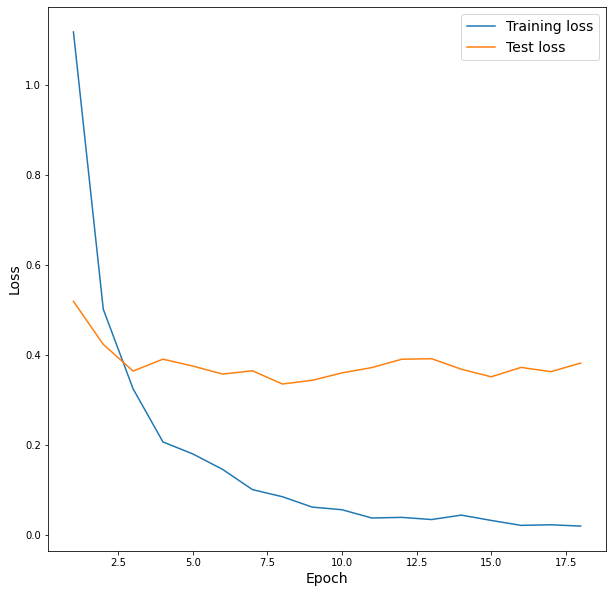

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(epoch_number, stored_train_loss,epoch_number,stored_test_loss)
ax.set_xlabel('Epoch', fontsize = 14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(('Training loss','Test loss'), fontsize=14)